# Food 11 Image Classification Notebook

This notebook will be used to design & train 4 different powerful image classifications model to detect different types of Image Classification Models. 

The four different models which will be trained are: 
1. ResNet - Residual Connections allow for deeper network training without vanishing gradients. 
2. EfficientNet - Scaled width, depth and resolution in a balanced way
3. DenseNet - Dense connections encourage feature reuse
4. MobileNetV3 Small - Benefits from color/texture cues

In [1]:
import os 
import sys 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import array_to_img
import cv2 
import tensorflow_hub as hub
import pathlib
from pathlib import Path
import random
import shutil

In [2]:
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: /Users/saikeerthan/Official_PersonalProject/food-11-image-classification


In [3]:
import os
import shutil
from pathlib import Path
from collections import Counter

# --- paths ---
ROOT = Path("/Users/saikeerthan/Official_PersonalProject/food-11-image-classification/food11")
TRAIN = ROOT / "train"
TEST = ROOT / "test"
COMBINED = ROOT / "combined"   


MOVE_FILES = False

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def unique_target(dst_dir: Path, filename: str) -> Path:
    """Return a unique destination path if filename already exists."""
    stem, suffix = Path(filename).stem, Path(filename).suffix
    candidate = dst_dir / filename
    i = 1
    while candidate.exists():
        candidate = dst_dir / f"{stem}_dup{i}{suffix}"
        i += 1
    return candidate

def gather_classes(*dirs):
    classes = set()
    for d in dirs:
        if d.exists():
            for p in d.iterdir():
                if p.is_dir():
                    classes.add(p.name)
    return sorted(classes)

def transfer_files(src_dir: Path, dst_dir: Path) -> Counter:
    counts = Counter()
    if not src_dir.exists():
        return counts
    for f in src_dir.iterdir():
        if not f.is_file():
            continue
        target = unique_target(dst_dir, f.name)
        if MOVE_FILES:
            shutil.move(str(f), str(target))
        else:
            shutil.copy2(str(f), str(target))
        counts["moved" if MOVE_FILES else "copied"] += 1
    return counts

def main():
    ensure_dir(COMBINED)
    classes = gather_classes(TRAIN, TEST)
    totals = Counter()

    for cls in classes:
        src_train = TRAIN / cls
        src_test  = TEST / cls
        dst = COMBINED / cls
        ensure_dir(dst)

        totals += transfer_files(src_train, dst)
        totals += transfer_files(src_test, dst)

    print("✅ Merge complete:")
    for cls in classes:
        n = sum(1 for _ in (COMBINED/cls).glob("*") if _.is_file())
        print(f"  - {cls}: {n} files")
    print(f"Total {('moved' if MOVE_FILES else 'copied')}: {totals['moved' if MOVE_FILES else 'copied']}")

if __name__ == "__main__":
    main()

✅ Merge complete:
  - apple_pie: 1000 files
  - cheesecake: 1000 files
  - chicken_curry: 1000 files
  - french_fries: 1000 files
  - fried_rice: 1000 files
  - hamburger: 1000 files
  - hot_dog: 1000 files
  - ice_cream: 1000 files
  - omelette: 1000 files
  - pizza: 1000 files
  - sushi: 1000 files
Total copied: 11000


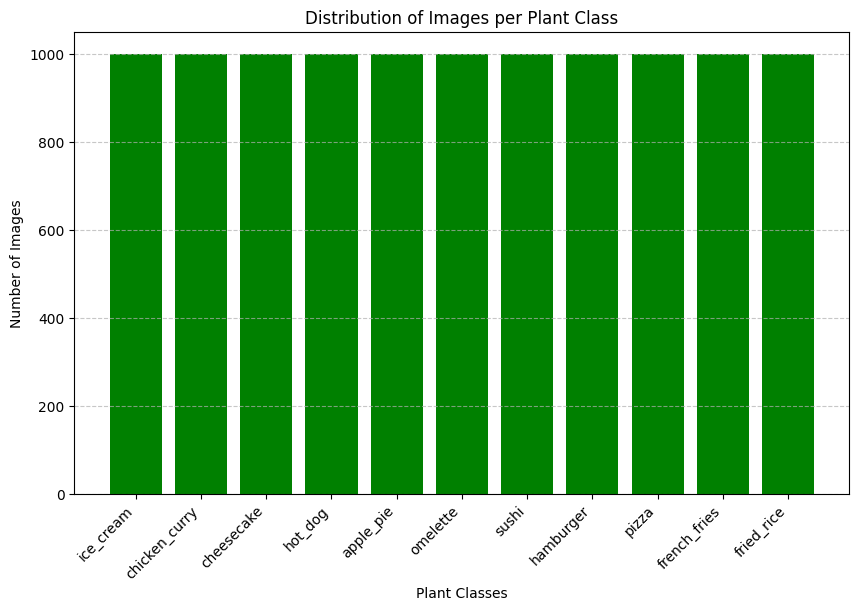

In [4]:
dataset_path = "/Users/saikeerthan/Official_PersonalProject/food-11-image-classification/food11/combined"

# Get the list of class names (subdirectories)
num_classes = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_classes[class_name] = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(num_classes.keys(), num_classes.values(), color='green')
plt.xlabel("Plant Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Plant Class")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
for class_names, count in num_classes.items():
    print(f"{class_names}: {count} images")

ice_cream: 1000 images
chicken_curry: 1000 images
cheesecake: 1000 images
hot_dog: 1000 images
apple_pie: 1000 images
omelette: 1000 images
sushi: 1000 images
hamburger: 1000 images
pizza: 1000 images
french_fries: 1000 images
fried_rice: 1000 images


## Use Tensorflow to split into train test val

In [6]:
data_dir = COMBINED
output_dir = ROOT / "final_data"

batch_size = 32
image_height = 224
image_width = 224
seed = 42

In [7]:
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=seed,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode='categorical'
)

val_test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed=seed,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode='categorical'
)

val_test_dataset = val_test_dataset.unbatch()
val_test_dataset = val_test_dataset.shuffle(1000, seed=seed)

val_test_count = sum(1 for _ in val_test_dataset)
val_count = test_count = val_test_count // 2

val_dataset = val_test_dataset.take(val_count).batch(batch_size)
test_dataset = val_test_dataset.skip(val_count).batch(batch_size)


Found 11000 files belonging to 11 classes.
Using 8800 files for training.
Found 11000 files belonging to 11 classes.
Using 2200 files for validation.


2025-09-04 20:14:32.196331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# def save_dataset(dataset, dest_dir, dataset_type, class_names):
#     """
#     Saves images from a tf.data.Dataset into destination folder,
#     naming each file as:
#         <dataset_type>_batch<batch_index>_img<image_index>_<class_name>.jpg
#     e.g. train_batch0_img0_tomato_blight.jpg
#     """
#     for batch_idx, (images, labels) in enumerate(dataset):
#         for i in range(len(images)):
#             # Determine class name from one-hot label
#             class_label = class_names[tf.argmax(labels[i]).numpy()]

#             # Create the subfolder for this class
#             class_folder = os.path.join(dest_dir, class_label)
#             os.makedirs(class_folder, exist_ok=True)

#             # Convert the image tensor to a PIL Image
#             image = array_to_img(images[i])
#             # Create a descriptive filename
#             filename = f"{dataset_type}_batch{batch_idx}_img{i}_{class_label}.jpg"
#             image_path = os.path.join(class_folder, filename)

#             # Save the image
#             image.save(image_path)

# save_dataset(train_dataset, train_dir, "train", class_names)
# save_dataset(val_dataset, val_dir, "val", class_names)
# save_dataset(test_dataset, test_dir, "test", class_names)

## MobileNetV3 Small

In [9]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Input, GlobalMaxPooling2D, Dropout, BatchNormalization, Activation, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model = MobileNetV3Small(weights='imagenet', include_top=False)

/Users/saikeerthan/Official_PersonalProject/personal_venv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [10]:
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable= True

gap = GlobalAveragePooling2D()(base_model.output)
gmp = GlobalMaxPooling2D()(base_model.output)

combined_pool = Concatenate()([gap, gmp])
combined_pool = BatchNormalization()(combined_pool)

X = Dense(512, kernel_regularizer=l2(0.001))(combined_pool)
X = Activation("swish")(X)
X = BatchNormalization()(X)
X = Dropout(0.5)(X)

X = Dense(256, kernel_regularizer=l2(0.001))(X)
X = Activation("swish")(X)
X = Dropout(0.5)(X)

X = Dense(128, kernel_regularizer=l2(0.001))(X)
X = Activation("swish")(X)
X = BatchNormalization()(X)


preds = Dense(len(num_classes), activation='softmax')(X)

v3_food = Model(inputs=base_model.input, outputs=preds)

v3_food.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=["categorical_accuracy"]
)

v3_food.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling[0][0]   │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, None,      │          0 │ re_lu[0][0],      │
│ (Multiply)          │ None, 16)         │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        256 │ expanded_conv_sq

 Total params: 1,702,267 (6.49 MB)

 Trainable params: 1,496,147 (5.71 MB)

 Non-trainable params: 206,120 (805.16 KB)

In [11]:
epochs = 30
optimizer = Adam(learning_rate=0.001)

check_point = ModelCheckpoint(filepath="/Users/saikeerthan/Official_PersonalProject/food-11-image-classification/Models/V3Small/1.0/checkpoints/flora-{epoch:02d}-{val_categorical_accuracy:.2f}.h5",
                             monitor='val_categorical_accuracy',
                             save_best_only=True,
                             mode='max')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    mode="auto",
    patience=5, 
    restore_best_weights=True,
    start_from_epoch=0)

v3_food.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])
history = v3_food.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, check_point])

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_accuracy: 0.4836 - loss: 2.8809

2025-09-04 20:15:20.180873: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/saikeerthan/Official_PersonalProject/personal_venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - categorical_accuracy: 0.6257 - loss: 2.4202 - val_categorical_accuracy: 0.6000 - val_loss: 2.6495
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - categorical_accuracy: 0.7682 - loss: 1.8507

275/275 ━━━━━━━━━━━━━━━━━━━━ 44s 159ms/step - categorical_accuracy: 0.7893 - loss: 1.7562 - val_categorical_accuracy: 0.7245 - val_loss: 1.9465
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categorical_accuracy: 0.8416 - loss: 1.4634

2025-09-04 20:16:46.585634: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


275/275 ━━━━━━━━━━━━━━━━━━━━ 43s 155ms/step - categorical_accuracy: 0.8535 - loss: 1.3832 - val_categorical_accuracy: 0.7627 - val_loss: 1.6600
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_accuracy: 0.8661 - loss: 1.2106

275/275 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - categorical_accuracy: 0.8689 - loss: 1.1612 - val_categorical_accuracy: 0.7673 - val_loss: 1.4951
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 46s 166ms/step - categorical_accuracy: 0.8988 - loss: 0.9353 - val_categorical_accuracy: 0.6891 - val_loss: 1.7916
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 180ms/step - categorical_accuracy: 0.9156 - loss: 0.7809 - val_categorical_accuracy: 0.7318 - val_loss: 1.5900
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - categorical_accuracy: 0.9126 - loss: 0.7267

2025-09-04 20:19:54.937193: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


275/275 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - categorical_accuracy: 0.9195 - loss: 0.6947 - val_categorical_accuracy: 0.7900 - val_loss: 1.2523
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - categorical_accuracy: 0.9256 - loss: 0.6007 - val_categorical_accuracy: 0.7827 - val_loss: 1.3278
Epoch 9/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - categorical_accuracy: 0.9381 - loss: 0.5280 - val_categorical_accuracy: 0.7882 - val_loss: 1.2402
Epoch 10/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - categorical_accuracy: 0.9433 - loss: 0.4808 - val_categorical_accuracy: 0.7282 - val_loss: 1.5136
Epoch 11/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 49s 179ms/step - categorical_accuracy: 0.9399 - loss: 0.4796 - val_categorical_accuracy: 0.7673 - val_loss: 1.3163
Epoch 12/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 50s 182ms/step - categorical_accuracy: 0.9489 - loss: 0.4360 - val_categorical_accuracy: 0.7709 - val_loss: 1.2264
Epoch 13/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categorical_accuracy:

275/275 ━━━━━━━━━━━━━━━━━━━━ 49s 178ms/step - categorical_accuracy: 0.9532 - loss: 0.4075 - val_categorical_accuracy: 0.8000 - val_loss: 1.1502
Epoch 14/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - categorical_accuracy: 0.9471 - loss: 0.4261

275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 176ms/step - categorical_accuracy: 0.9515 - loss: 0.4120 - val_categorical_accuracy: 0.8091 - val_loss: 1.0737
Epoch 15/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 46s 168ms/step - categorical_accuracy: 0.9607 - loss: 0.3665 - val_categorical_accuracy: 0.7964 - val_loss: 1.2560
Epoch 16/30


2025-09-04 20:26:28.737361: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


275/275 ━━━━━━━━━━━━━━━━━━━━ 49s 177ms/step - categorical_accuracy: 0.9600 - loss: 0.3713 - val_categorical_accuracy: 0.7991 - val_loss: 1.1183
Epoch 17/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step - categorical_accuracy: 0.9616 - loss: 0.3638 - val_categorical_accuracy: 0.7800 - val_loss: 1.2333
Epoch 18/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 45s 163ms/step - categorical_accuracy: 0.9616 - loss: 0.3512 - val_categorical_accuracy: 0.7664 - val_loss: 1.3152
Epoch 19/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 46s 168ms/step - categorical_accuracy: 0.9591 - loss: 0.3646 - val_categorical_accuracy: 0.7645 - val_loss: 1.4297


In [13]:
v3_food.save('/Users/saikeerthan/Official_PersonalProject/food-11-image-classification/Models/V3Small/1.0/v3_food.keras')

In [14]:
test_loss_final, test_acc_final= v3_food.evaluate(test_dataset)
print(f"Final Test loss: {test_loss_final:.3f}")
print(f"Final Test accuracy: {test_acc_final:.3f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - categorical_accuracy: 0.7991 - loss: 1.1257
Final Test loss: 1.126
Final Test accuracy: 0.799


/Users/saikeerthan/Official_PersonalProject/personal_venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

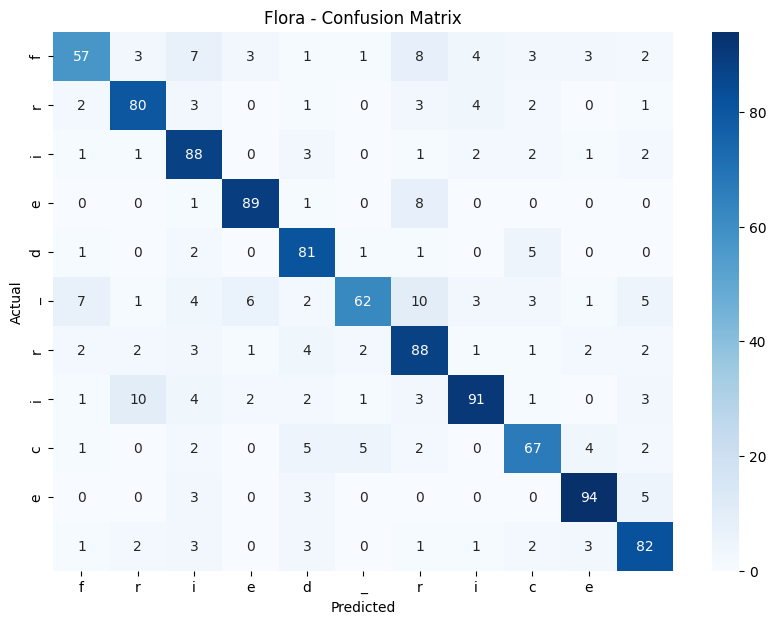

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

y_gt = []
y_predictions = []

for images, labels in test_dataset:
    predictions = v3_food.predict(images)
    y_gt.extend(np.argmax(labels.numpy(), axis=1))
    y_predictions.extend(np.argmax(predictions, axis=1))

matrix = confusion_matrix(y_true=y_gt, y_pred=y_predictions)

plt.figure(figsize=(10,7))
sns.heatmap(matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Flora - Confusion Matrix")
plt.show()